In [1]:
#one hot encoding + xgboost (svm took too long to train)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('datasets/train_transaction.csv')
#df_val = pd.read_csv('datasets/test_transaction.csv')
df.shape
df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [12]:
features = ['isFraud', 'TransactionDT',
            'TransactionAmt','ProductCD', 'P_emaildomain', 'R_emaildomain']

#drop R_emaildomain. too many null value

df = df[features]

target = 'isFraud'
y = df[target]
cat = ['ProductCD', 'P_emaildomain','R_emaildomain']
num = ['TransactionAmt', 'TransactionDT']

In [13]:
#null value strategy
#no nulls in ProductCD, TransactionDT, TransactionAmt

df['ProductCD'].head()
df['ProductCD'].value_counts()

df['ProductCD'].isna().sum()

df['TransactionDT'].isna().sum()
df['TransactionAmt'].isna().sum()


0

In [14]:
#one hot encoding
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[cat]))

#put index back since ohehot encoding ggets rid of index
OH_cols.index = df.index
  
print(OH_cols.shape, df[num].shape)
OH_cols.head()

# Merge with main
# kernel dies here
processed_X = pd.concat([OH_cols, df[num]], axis=1)
print(processed_X.shape) # getting weird shape. how did we end up with 201643 rows when we should have gotten 126227?
# processed_X.head()

#make sure every column has string type
processed_X.columns = processed_X.columns.astype(str)
processed_X.shape

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(processed_X, y)

(590540, 126) (590540, 2)
(590540, 128)


In [16]:
import sys
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-1.7.5-py3-none-macosx_12_0_arm64.whl (1.6 MB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [66]:
from xgboost import XGBClassifier

my_model = XGBClassifier(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

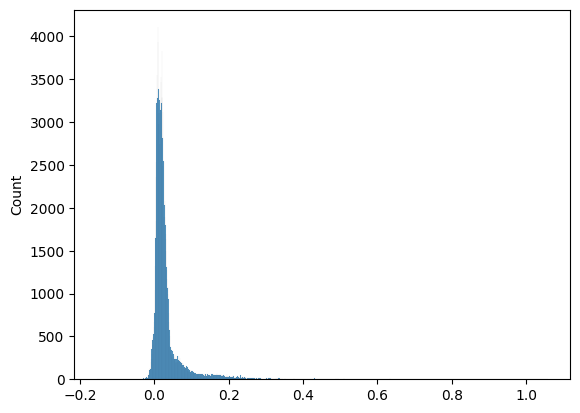

In [63]:
#process validation data the same way
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
predictions = my_model.predict(X_valid)
predictions_series = pd.Series(predictions)

import seaborn as sns

sns.histplot(data = predictions_series)
threshold = 0.36

predictions_bin = predictions_series.map(lambda x: 1 if x >threshold else 0)






0.9682189182781861


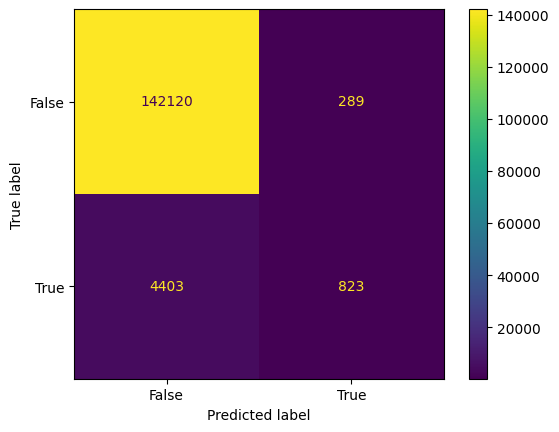

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib as plt

confusion_matrix = confusion_matrix(y_valid, predictions_bin)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
print(accuracy_score(predictions_bin, y_valid))
cm_display.plot()
#plt.show()


In [70]:
from collections import Counter
from sklearn.datasets import make_classification
import imbalanced-learn
from imblearn.under_sampling import TomekLinks

X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
tl = TomekLinks()

X_res, y_res = tl.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

SyntaxError: invalid syntax (491811380.py, line 3)